In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns
from joblib import Parallel, delayed

sns.set_palette('Set2')
cmap = sns.color_palette('Set2')

In [3]:
importlib.reload(bp)

<module 'Branching_Process' from '/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py'>

In [6]:
Tmax = 200
nsteps = 2*Tmax +1 
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
beta_test = 2/7
gamma_test = 1/7
omega = beta_test + gamma_test
growth_rate = beta_test - gamma_test
R_eff = 4
t_lockdown = 30

eta = 1
eta2 = 0.5
# From FF100 data, Challen et al. 2021 Meta-analysis
gmean = 4.87
gsd = 1.98
alpha = gmean**2 / gsd**2
beta = gsd**2 / gmean



def lifetime(t, tau):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t, tau):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)


def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)

def R_constant(t, R=R_eff):
    return R 


def lifetime_exp(t, tau):
    return sp.stats.expon.cdf(t, scale = 1/omega)

def infectiousness_const(t, const = 1):
    return const * np.ones_like(t)

def R_lockdown(t, R1 = R_eff, R2 = 1, t_lockdown = t_lockdown):
    return R1 * (t<=t_lockdown)  + R2 * (1-(t <= t_lockdown))

def R_constant(t, R=R_eff):
    return R    

# Define individual offspring distribution

def logarithmic_offspring(z, phi = 0.1):
    return - phi * (np.log(phi + 1 - z) - np.log(phi))

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)


def const_immigration(z, eta = eta):
    return eta*np.ones_like(z)

def exp_dist_immigration(tau, eta = eta):
    return np.exp(-eta*tau)

def exp_int_immigration(tau, eta = eta):
    return 1/eta * (1-np.exp(-eta * tau))


def exp_immigration(tau, eta = eta):
    return eta*np.exp(eta*tau)

cmj_test = bp.cmj(poisson_offspring, time=time)
cmj_test.set_lifetime_distribution(lifetime)
cmj_test.set_infectiousness_profile(infectiousness)
cmj_test.set_transmission_rate(R_constant)


#cmj_lockdown = bp.cmj(poisson_offspring, time=time)
#cmj_lockdown.set_lifetime_distribution(lifetime)
#cmj_lockdown.set_infectiousness_profile(infectiousness)
#cmj_lockdown.set_transmission_rate(Rt)


cmj_immigration = bp.cmj(poisson_offspring, time=time)
cmj_immigration.set_lifetime_distribution(lifetime)
cmj_immigration.set_infectiousness_profile(infectiousness)
cmj_immigration.set_transmission_rate(R_constant)
cmj_immigration.set_immigration(const_immigration)






def intensity_measure(t):
    return R_constant(t) * infectiousness_pdf(t) * (1-lifetime(t, 0))

#lifespan_average = np.linspace(0, a/b)

R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

R0 is: 2.0000000000000204


In [7]:
max_pgf = 20000

n_cores = 6
characteristic = 'prev'

# Calculate pmf - parallelise for faster results 
start = timer()

pmf_immigration = bp.pmfft(cmj_immigration.pgf_immigration, 
                    max_pgf,
                    immigration = const_immigration,
                    parallel = True,
                    n_cores = n_cores)
    
#pmf_test = bp.pmfft(cmj_immigration.pgf_vec, 
##                    max_pgf, 
 #                   count = 'prev',
 #                   parallel = True,
 #                   n_cores = n_cores)


stop = timer()
print('Runs in ' + str(stop - start) + ' seconds on ' + str(n_cores) + ' cores')

# Uncomment if you want to save this 



Runs in 2008.4005262851715 seconds on 6 cores


/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py:435: RuntimeWarning: invalid value encountered in divide
  FPT_cdf[i] = (1-(np.cumsum(pmf[:Zstar, i]))[-1])/(1-(np.cumsum(pmf[0, i])))


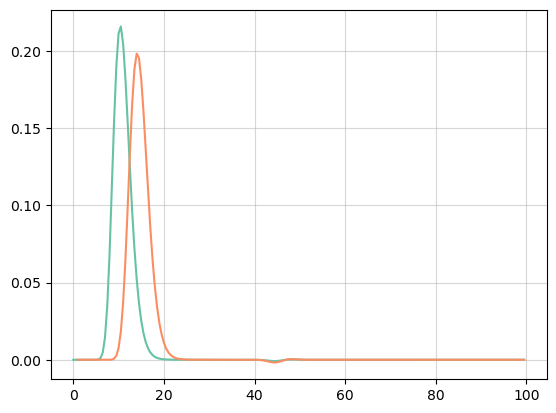

In [8]:
beep = np.zeros_like(time)
for i in range(nsteps):
    beep[i] = (1-(np.cumsum(pmf_immigration[:50, i]))[-1]) # 
fpt = bp.FirstPassageTime(pmf_immigration, 100, time)
plt.grid(alpha = 0.5)
plt.plot(time[:200], np.gradient(beep[:200], time_step))
plt.plot(time[:200], fpt[:200])
#plt.ylim([0, np.max(beep)*(1.02)])


In [10]:
def quick_mean(N, Delta, G, V, rho, BH = False, count = None, immigration = None):
    if count == 'ci':
        def h(t, tau):
            return 1
        
    elif count == 'incidence':
        def h(t, tau):
            return lifetime_pdf(t-tau, tau)
        
    else:
        def h(t, tau):
            return 1 - G(t - tau, tau)
    
    if BH:
        def lam(t, tau):
            return rho(t + tau) * np.gradient(G, Delta)
    else:
        def lam(t, tau):
            return rho(t + tau) * (V(t) - V(t-Delta)) * (1 - G(t, tau))
  
    fhat = np.zeros(shape = (N + 1, N + 1))

    for n in range(N + 1):
        for i in range(n + 1):
            if i == 0:
                fhat[n, i] = h(n * Delta, n * Delta)
            else:
                fhat[n, i] = h(n * Delta, (n - i) * Delta) + np.sum(fhat[n, i - np.arange(1, i + 1)] * lam(Delta * np.arange(1, i + 1), (n - i) * Delta))

    #return fhat
    return np.diagonal(fhat)

quick_mn = quick_mean(nsteps, time_step, lifetime, infectiousness, R_constant, count = 'prev')





This gets dodgy from I = 223


100%|██████████| 400/400 [00:00<00:00, 1754.70it/s]


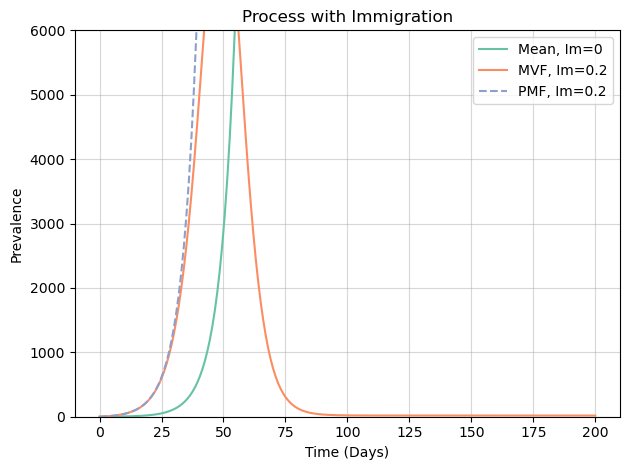

In [21]:
def foi_t(t, time_step = time_step):
    return R_constant(t) * (infectiousness(t) - infectiousness(t-time_step)) * (1 - lifetime(t, 0))

im_switch = 1
N = 50000
print('This gets dodgy from I = ' + str(int(np.sqrt(N))))
i0 = 1/N
s0 = (1-i0)
S = np.zeros(nsteps)
I = np.zeros(nsteps)
CI = np.zeros(nsteps)
I[0] = i0
S[0] = 1 - i0
CI[0] = i0
stopping = 500

prev = I
linear = I

integral = np.zeros((nsteps, nsteps))
integral[0, 0] = i0

 
integral_inc = np.zeros((nsteps, nsteps))
new_prev = np.zeros(nsteps)
new_prev[0] = 0
start_prev = new_prev[0]
sus = np.zeros(nsteps)
sus[0] = N*(1-i0)

incidence = np.zeros(nsteps)

for n in tqdm(range(1, nsteps)):
    start = 0#(lifetime_pdf(time[n], 0))
    if im_switch:
        new_inc =  start +(sus[n-1]/N) *  np.sum(foi_t(time[:]) * integral_inc[:, n]) + const_immigration(time[n])#exp_dist_immigration(time)[n]
    else:
        new_inc =  start + np.sum(foi_t(time[:]) * integral_inc[:, n]) + sp.integrate.quad(const_immigration, time[n-1], time[n])[0] / time_step #(exp_immigration(time[n-1])-exp_immigration(time[n]))/(eta*time_step)
    incidence[n] = new_inc
    integral_inc += np.diag(new_inc*np.ones_like(np.diag(integral_inc, n)), n)
    
    new_prev[n] = start_prev + np.sum(((integral_inc[:, n])) * (1-lifetime(time, 0)))
    
    sus[n] = sus[n-1] - new_inc

mn_immigration = bp.mean_pmf(pmf_immigration)

plt.grid(alpha = 0.5)
plt.plot(time, quick_mn[:-1], label = 'Mean, Im=0')
plt.plot(time, new_prev, label = 'MVF, Im=0.2')
plt.plot(time, mn_immigration[:-1] , '--', label = 'PMF, Im=0.2')
#plt.plot(time, time, '.')
plt.legend()
#plt.xlim([0, 100])
plt.ylim([0, 6000])
plt.ylabel('Prevalence')
plt.xlabel('Time (Days)')
plt.title('Process with Immigration')
plt.tight_layout()

In [186]:
#mn_test = bp.mean_pmf(pmf_test)

(exp_immigration(time[n-1])-exp_immigration(time[n]))/eta

2.234016586697872e-18

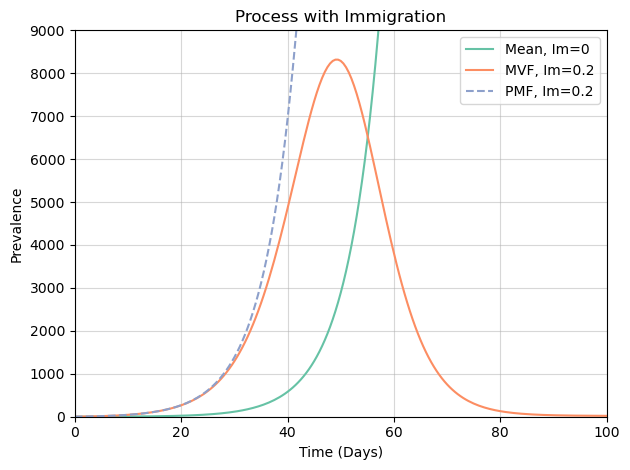

In [26]:
plt.grid(alpha = 0.5)
plt.plot(time, quick_mn[:-1], label = 'Mean, Im=0')
plt.plot(time, new_prev, label = 'MVF, Im=0.2')
plt.plot(time, mn_immigration[:-1] , '--', label = 'PMF, Im=0.2')
#plt.plot(time, time, '.')
plt.legend()
plt.xlim([0, 100])
plt.ylim([0, 9000])
plt.ylabel('Prevalence')
plt.xlabel('Time (Days)')
plt.title('Process with Immigration')
plt.tight_layout()
#plt.savefig('Figures/Immigration_comparison.png')

/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py:453: RuntimeWarning: invalid value encountered in divide
  FPT_cdf[i] = (1-(np.cumsum(pmf[:Zstar, i]))[-1])/(1-(np.cumsum(pmf[0, i])))


-0.0005890469045606306

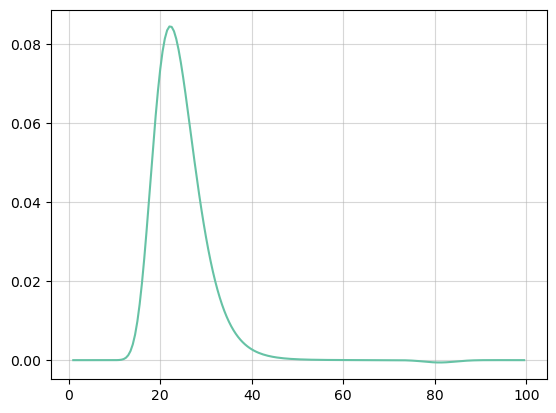

In [9]:

beep = np.zeros_like(time)
for i in range(nsteps):
    beep[i] = (1-(np.cumsum(pmf_immigration[:50, i]))[-1]) # 
beep = bp.FirstPassageTime(pmf_immigration, 100, time)
plt.grid(alpha = 0.5)
plt.plot(time[:200], beep[:200])
#plt.ylim([0, np.max(beep)*(1.02)])
np.min(beep[5:200])

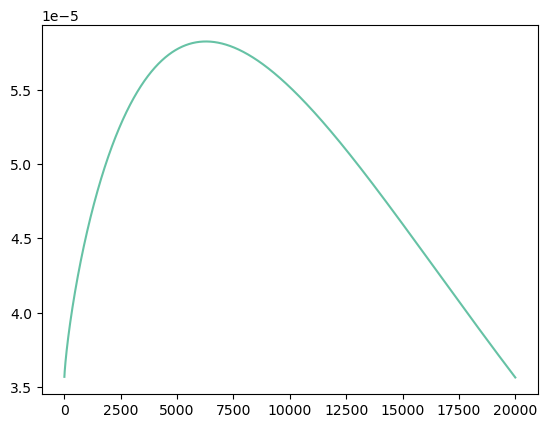

In [104]:
#plt.plot(time, np.real_if_close(cmj_immigration.pgf_immigration(0, const_immigration))[:-1])
plt.plot(pmf_immigration[:, 200])